In [ ]:
!nvidia-smi

Mon Nov 15 05:38:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/HW2/hw2_data.zip

串流輸出內容已截斷至最後 5000 行。
 extracting: hw2_data/face/train/31182.png  
 extracting: hw2_data/face/train/35296.png  
 extracting: hw2_data/face/train/29882.png  
  inflating: hw2_data/face/train/21095.png  
 extracting: hw2_data/face/train/23957.png  
  inflating: hw2_data/face/train/30313.png  
 extracting: hw2_data/face/train/11616.png  
 extracting: hw2_data/face/train/10447.png  
 extracting: hw2_data/face/train/34172.png  
 extracting: hw2_data/face/train/35917.png  
 extracting: hw2_data/face/train/18720.png  
 extracting: hw2_data/face/train/10484.png  
 extracting: hw2_data/face/train/25579.png  
 extracting: hw2_data/face/train/11294.png  
 extracting: hw2_data/face/train/21343.png  
 extracting: hw2_data/face/train/30592.png  
 extracting: hw2_data/face/train/05946.png  
 extracting: hw2_data/face/train/36061.png  
 extracting: hw2_data/face/train/07383.png  
 extracting: hw2_data/face/train/05793.png  
 extracting: hw2_data/face/train/04351.png  
 extracting: hw2_data/face/train/2

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image, ImageEnhance, ImageOps
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.utils import save_image

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [ ]:
# Batch size during training
batch_size = 50

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

num_classes = 10

sample_interval = 600

In [ ]:
train_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Define dataloader

In [ ]:
class Image_Dataset(Dataset):
    def __init__(self, root, train=True, trans=None):
      self.train = train
      self.root = root
      self.transform = trans
      self.data_name = pd.read_csv(self.root)['image_name'].tolist()
      self.data_label = pd.read_csv(self.root)['label'].tolist()

    def __getitem__(self, index):
      if self.train == 'train':
        self.img = Image.open('/content/hw2_data/digits/mnistm/train/' + self.data_name[index])
        self.img = self.transform(self.img)
        self.label = self.data_label[index]
      else:
        self.img = Image.open('/content/hw2_data/digits/mnistm/test/' + self.data_name[index])
        self.img = self.transform(self.img)
        self.label = self.data_label[index]

      return (self.img, self.label)

    def __len__(self):
      return len(self.data_name)

train_set = Image_Dataset('/content/hw2_data/digits/mnistm/train.csv', train='train', trans=train_tfm)
valid_set = Image_Dataset('/content/hw2_data/digits/mnistm/test.csv', train='val', trans=test_tfm)

train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_data = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Weight Initialization

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, img_size):
      self.channel = 3
      super(Generator, self).__init__()

      self.label_emb = nn.Embedding(n_classes, latent_dim)

      self.init_size = img_size // 4  # Initial size before upsampling
      self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

      self.conv_blocks = nn.Sequential(
          nn.BatchNorm2d(128),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 128, 3, stride=1, padding=1),
          nn.BatchNorm2d(128, 0.8),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, 3, stride=1, padding=1),
          nn.BatchNorm2d(64, 0.8),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(64, self.channel, 3, stride=1, padding=1),
          nn.Tanh(),
      )

    def forward(self, noise, labels):
      gen_input = torch.mul(self.label_emb(labels), noise)
      out = self.l1(gen_input)
      out = out.view(out.shape[0], 128, self.init_size, self.init_size)
      img = self.conv_blocks(out)
      return img

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_classes, img_size):
        super(Discriminator, self).__init__()
        self.channel = 3
        self.n_classes = n_classes
        self.init_size = img_size
        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(self.channel, 16, bn=True),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = self.init_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, self.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label

In [ ]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator(nz, num_classes, image_size)
discriminator = Discriminator(num_classes, image_size)

cuda = True if torch.cuda.is_available() else False
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done, latent_dim):
  """Saves a grid of generated digits ranging from 0 to n_classes"""
  # Sample noise
  z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
  # Get labels ranging from 0 to n_classes for n rows
  labels = np.array([num for _ in range(n_row) for num in range(n_row)])
  labels = Variable(LongTensor(labels))
  gen_imgs = generator(z, labels)
  # save_image(gen_imgs.data, "/content/train_image/%d.png" % batches_done, nrow=n_row, normalize=True)

# Define Varivales

In [ ]:
try:
  os.system('rm -r /content/train_image')
except:
  pass
  
!mkdir /content/train_image

# Training

In [ ]:
for epoch in range(10):
  for i, (imgs, labels) in enumerate(train_data):

    batch_size = imgs.shape[0]

    # Adversarial ground truths
    valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
    fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

    # Configure input
    real_imgs = Variable(imgs.type(FloatTensor))
    labels = Variable(labels.type(LongTensor))

    # -----------------
    #  Train Generator
    # -----------------

    optimizer_G.zero_grad()

    # Sample noise and labels as generator input
    z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, nz))))
    gen_labels = Variable(LongTensor(np.random.randint(0, num_classes, batch_size)))

    # Generate a batch of images
    gen_imgs = generator(z, gen_labels)

    # Loss measures generator's ability to fool the discriminator
    validity, pred_label = discriminator(gen_imgs)
    g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

    g_loss.backward()
    optimizer_G.step()

    # ---------------------
    #  Train Discriminator
    # ---------------------

    optimizer_D.zero_grad()

    # Loss for real images
    real_pred, real_aux = discriminator(real_imgs)
    d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

    # Loss for fake images
    fake_pred, fake_aux = discriminator(gen_imgs.detach())
    d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

    # Total discriminator loss
    d_loss = (d_real_loss + d_fake_loss) / 2

    # Calculate discriminator accuracy
    pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
    gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
    d_acc = np.mean(np.argmax(pred, axis=1) == gt)

    d_loss.backward()
    optimizer_D.step()

    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
        % (epoch, num_epochs, i, len(train_data), d_loss.item(), 100 * d_acc, g_loss.item())
    )
    batches_done = epoch * len(train_data) + i
    if batches_done % sample_interval == 0:
        sample_image(n_row=10, batches_done=batches_done, latent_dim=nz)
  # save model
  if epoch >= 0:
    torch.save(generator.state_dict(),  '/content/drive/MyDrive/HW2/model/acgan/acgan_%s.pth'%str(epoch+90)) # 'xxx.pth' #保存模型

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


串流輸出內容已截斷至最後 5000 行。
[Epoch 5/100] [Batch 1000/1200] [D loss: 1.107919, acc: 96%] [G loss: 1.140964]
[Epoch 5/100] [Batch 1001/1200] [D loss: 1.069853, acc: 94%] [G loss: 1.145008]
[Epoch 5/100] [Batch 1002/1200] [D loss: 1.088674, acc: 96%] [G loss: 1.153834]
[Epoch 5/100] [Batch 1003/1200] [D loss: 1.108976, acc: 99%] [G loss: 1.139752]
[Epoch 5/100] [Batch 1004/1200] [D loss: 1.155850, acc: 98%] [G loss: 1.173922]
[Epoch 5/100] [Batch 1005/1200] [D loss: 1.098749, acc: 94%] [G loss: 1.083999]
[Epoch 5/100] [Batch 1006/1200] [D loss: 1.046738, acc: 91%] [G loss: 1.120229]
[Epoch 5/100] [Batch 1007/1200] [D loss: 1.081867, acc: 98%] [G loss: 1.097248]
[Epoch 5/100] [Batch 1008/1200] [D loss: 1.056588, acc: 97%] [G loss: 1.051139]
[Epoch 5/100] [Batch 1009/1200] [D loss: 1.072111, acc: 97%] [G loss: 1.121292]
[Epoch 5/100] [Batch 1010/1200] [D loss: 1.082697, acc: 97%] [G loss: 1.055700]
[Epoch 5/100] [Batch 1011/1200] [D loss: 1.085702, acc: 91%] [G loss: 1.082667]
[Epoch 5/100] [Batc

# Prediction

In [ ]:
import torch as t

model1 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_90.pth')
model2 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_99.pth')
model3 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_98.pth')
model4 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_97.pth')
model5 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_96.pth')
model6 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_95.pth')
model7 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_94.pth')
model8 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_93.pth')
model9 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_92.pth')
model10 = t.load('/content/drive/MyDrive/HW2/model/acgan/acgan_91.pth')

for key, value in model1.items():
      model1[key] = (value + model2[key] + model3[key] + model4[key] + model5[key] + model6[key] + model7[key] + model8[key] + model9[key] + model10[key]) / 10

generator = Generator(nz, num_classes, image_size).cuda()
generator.load_state_dict(model1)

t.save(generator.state_dict(),  '/content/drive/MyDrive/HW2/model/acgan/acgan_ensemble.pth')

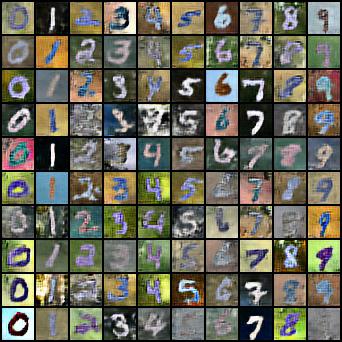

In [ ]:
generator = Generator(nz, num_classes, image_size).cuda()
generator.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/acgan/acgan_ensemble.pth'))

generator.eval()
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

def show_image(n_row, latent_dim):
  np.random.seed(0)
  """Saves a grid of generated digits ranging from 0 to n_classes"""
  # Sample noise
  z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
  # Get labels ranging from 0 to n_classes for n rows
  labels = np.array([num for _ in range(n_row) for num in range(n_row)])
  labels = Variable(LongTensor(labels))
  gen_imgs = generator(z, labels)
  return gen_imgs
  # save_image(gen_imgs.data, "/content/train_image/%d.png" % batches_done, nrow=n_row, normalize=True)

demo_img = show_image(n_row=10, latent_dim=nz)
Image.fromarray(((np.transpose(vutils.make_grid(demo_img.cpu(),nrow=10, padding=2, normalize=True), (1,2,0))).numpy()*255).astype(np.uint8))

In [ ]:
generator = Generator(nz, num_classes, image_size).cuda()
generator.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/acgan/acgan_ensemble.pth'))
generator.eval()

def pred_image(number_sample, classes, noise_z):
  labels = np.array([(i*0) + classes for i in range(number_sample)])
  labels = Variable(LongTensor(labels))
  gen_imgs = generator(noise_z, labels)
  return gen_imgs

In [ ]:
np.array([num for _ in range(10) for num in range(20)])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [ ]:
image_name = ["%03d" % x for _ in range(10) for x in range(1, 101)]

np.random.seed(0)
z = Variable(FloatTensor(np.random.normal(0, 1, (10 ** 2, nz))))

c = 0
for j in range(10):
  pred_data = pred_image(number_sample=100, classes=j, noise_z=z)
  for i in pred_data:
    predimg = Image.fromarray(((np.transpose(vutils.make_grid(i.cpu(),nrow=10, padding=2, normalize=True), (1,2,0))).numpy()*255).astype(np.uint8))
    predimg = transforms.Resize((28,28))(predimg)
    predimg.save('/content/train_image/%s_%s.png'%(j, image_name[c]))
    c += 1
print(c)

1000


# Loading classifier



In [ ]:
!cp /content/drive/MyDrive/HW2/digit_classifier.py /content/digit_classifier.py
!cp /content/drive/MyDrive/HW2/Classifier.pth /content/Classifier.pth

In [ ]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(16 * 4 * 4, 128)
      self.fc2 = nn.Linear(128, 64)
      self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
def load_checkpoint(checkpoint_path, model):
    state = torch.load(checkpoint_path, map_location = "cuda")
    model.load_state_dict(state['state_dict'])
    print('model loaded from %s' % checkpoint_path)

net = Classifier()
path = "Classifier.pth"
load_checkpoint(path, net)

model loaded from Classifier.pth


In [ ]:
# accuracy

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

accuracy = 0

floader = os.listdir('/content/train_image')
for i in floader:
  img = Image.open('/content/train_image/' + i)
  img = tfm(img).reshape(1, 3, 28, 28)
  logits = net(img)
  pred_class = str(torch.argmax(logits).item())
  img_class = i.split('_')[0]
  if pred_class == img_class:
    accuracy += 1
print(accuracy/len(floader))

0.991
